## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-12-26 21:08:15.958202


{1: 24.2,
 5: 25.4,
 10: 26.1,
 20: 26.9,
 30: 27.8,
 40: 29.2,
 50: 30.9,
 60: 32.6,
 70: 34.6,
 80: 36.8,
 90: 40.2,
 95: 43.1,
 99: 49.70100000000002}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2025-01-08 14:10:01.115885


{1: 8.5,
 5: 8.6,
 10: 8.7,
 20: 8.9,
 30: 9.0,
 40: 9.1,
 50: 9.1,
 60: 9.2,
 70: 9.3,
 80: 9.5,
 90: 9.7,
 95: 9.8,
 99: 10.2}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2025-01-08 14:36:18.005183


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev3)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev3)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)


In [6]:
def wildeford_max_gdp_frac():
    gdp_frac = sq.mixture([[0.9, sq.lognorm(1/500, 1/100)],
                           [0.1, sq.lognorm(1/100, 1/20)]])
    percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
    percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)
    compute_frac = gdp_frac * percent_spent_on_compute * percent_spent_on_largest_model
    return {'total_frac': gdp_frac, 'compute_frac': compute_frac}


base_flop_per_dollar = sq.lognorm(18.2, 19.4) # https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
# I'd use 1.43e18 FLOP/$ if renting cloud compute for training (significantly higher for serving a product, and significantly lower if using your own compute -- but then the number depends on how long you amortize it over).
# Source: If renting cloud compute, pricing seems to be $1.89-2.40 per H100 hour. (Jack Clark says $2 with bulk discounts.) Going with $2/hr, with the H100's 1.98e15 FLOP/s (FP8) and assuming 40% utilization (for training), that's 1.98e15*.4*60*60/2 = 1.43e18 FLOP/$.
# https://jack-clark.net/2024/03/28/what-does-1025-versus-1026-mean/ and https://gpus.llm-utils.org/h100-gpu-cloud-availability-and-pricing/
flop_frontier_penalty = sq.norm(0, 1)

# https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': np.array(tai_flop_size),
             'algo_doubling_rate_max': sq.lognorm(0.5, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': base_flop_per_dollar - flop_frontier_penalty,
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': np.array(initial_pay),
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'],
             'spend_doubling_time': sq.lognorm(0.5, 2, lclip=0.1),
             'nonscaling_delay': delay }

variables

{'initial_gdp': <Distribution> 23320000000000.0 * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) (version 0.28-dev3),
 'tai_flop_size': array([27.2, 24.5, 34.5, ..., 29.7, 27.3, 29.5]),
 'algo_doubling_rate_max': <Distribution> lognorm(lognorm_mean=1.42, lognorm_sd=0.83, norm_mean=0.2, norm_sd=0.54) (version 0.28-dev3),
 'algo_doubling_rate_min': <Distribution> lognorm(lognorm_mean=1.09, lognorm_sd=0.48, norm_mean=0.0, norm_sd=0.42) (version 0.28-dev3),
 'min_reduction': 2,
 'max_reduction': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev3),
 'initial_flop_per_dollar': <Distribution> lognorm(lognorm_mean=18.79, lognorm_sd=0.36, norm_mean=2.93, norm_sd=0.02) - norm(mean=0.5, sd=0.3) (version 0.28-dev3),
 'flop_halving_rate': <Distribution> norm(mean=2.5, sd=0.

## GDP Frac

### GDP

In [7]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000)
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '24.8 trillion',
 5: '24.9 trillion',
 10: '25.0 trillion',
 20: '25.0 trillion',
 30: '25.0 trillion',
 40: '25.1 trillion',
 50: '25.1 trillion',
 60: '25.1 trillion',
 70: '25.2 trillion',
 80: '25.2 trillion',
 90: '25.3 trillion',
 95: '25.3 trillion',
 99: '25.4 trillion'}

#### Total % of GDP spent on entire project

In [8]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 17340.28it/s]


{1: 0.00146,
 5: 0.00208,
 10: 0.00247,
 20: 0.00312,
 30: 0.00368,
 40: 0.00424,
 50: 0.00486,
 60: 0.00555,
 70: 0.00653,
 80: 0.00804,
 90: 0.01268,
 95: 0.02258,
 99: 0.04114}

In [9]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.146%',
 5: '0.208%',
 10: '0.247%',
 20: '0.312%',
 30: '0.368%',
 40: '0.424%',
 50: '0.486%',
 60: '0.555%',
 70: '0.653%',
 80: '0.804%',
 90: '1.268%',
 95: '2.258%',
 99: '4.114%'}

In [10]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '36.8 billion',
 5: '52.2 billion',
 10: '61.9 billion',
 20: '78.5 billion',
 30: '92.1 billion',
 40: '106.6 billion',
 50: '122.3 billion',
 60: '139.6 billion',
 70: '164.2 billion',
 80: '202.0 billion',
 90: '317.8 billion',
 95: '565.8 billion',
 99: '1.0 trillion'}

#### Total % of GDP spent on compute for largest model

In [11]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6126.41it/s]


{1: '0.001%',
 5: '0.003%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.026%',
 50: '0.037%',
 60: '0.055%',
 70: '0.086%',
 80: '0.142%',
 90: '0.266%',
 95: '0.445%',
 99: '1.162%'}

In [12]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.001%',
 5: '0.003%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.026%',
 50: '0.037%',
 60: '0.055%',
 70: '0.086%',
 80: '0.142%',
 90: '0.266%',
 95: '0.445%',
 99: '1.162%'}

In [13]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '304.1 million',
 5: '860.6 million',
 10: '1.5 billion',
 20: '2.8 billion',
 30: '4.4 billion',
 40: '6.5 billion',
 50: '9.3 billion',
 60: '13.7 billion',
 70: '21.6 billion',
 80: '35.6 billion',
 90: '67.2 billion',
 95: '112.2 billion',
 99: '292.2 billion'}

In [14]:
def model():
    frac = wildeford_max_gdp_frac()
    return frac['total_frac'] / frac['compute_frac']

sq.get_percentiles(sq.sample(model, verbose=True, n=5000), digits=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3618.01it/s]


{1: 0.4,
 5: 1.0,
 10: 1.8,
 20: 3.3,
 30: 5.7,
 40: 9.0,
 50: 13.4,
 60: 20.8,
 70: 32.7,
 80: 56.0,
 90: 107.9,
 95: 198.2,
 99: 611.9}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 34.6 log FLOP (~39.8 decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.3 log FLOP (~191.7 quadrillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 20.2 log FLOP (~144.4 quintillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~285.2 million).
* This doubles every 1.2 year to a max of 0.001163% of GDP (initially ~290.4 million 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 34.6 logFLOP which costs 17.3 log 2025$USD to buy vs. WTP at 8.2 (buys 25.4 log FLOP or 25.4 2025-log-eFLOP)
2026 - TAI takes 34.4 logFLOP which costs 16.9 log 2025$USD to buy vs. WTP at 8.3 (buys 25.7 log FLOP or 25.9 2025-log-eFLOP)
2027 - TAI takes 34.1 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 8.4 (buys 25.9 log FLOP or 26.4 2025-log-eFLOP)
2028 - TAI takes 33.9 logFLOP which co

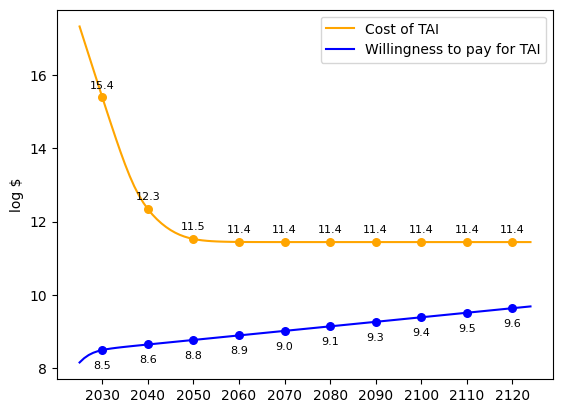



## SAMPLE RUN 2 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.4 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~347.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.1 billion).
* This doubles every 1.1 year to a max of 0.016252% of GDP (initially ~4.1 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 27.1 logFLOP which costs 8.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not occur
--- /!\ TAI CREATED in 2025


## SAMPLE RUN 3 ##

In this simulation:
* It takes 42.9 log F

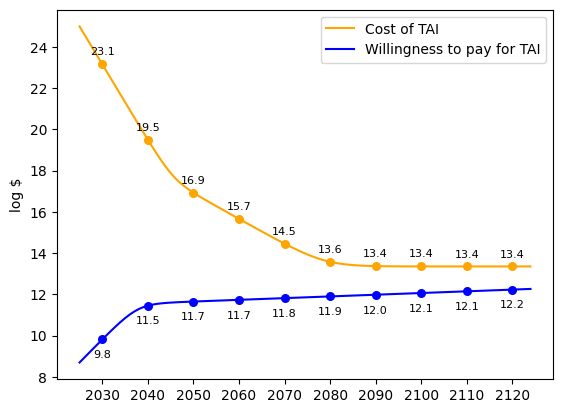



## RUN TIMELINES MODEL ##
Generating Bayes net with 12 cores...


10044it [00:11, 875.89it/s]                                                                                                                                                                                                                          


Shuffling data...
Writing data...
Waiting for other cores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1757.02it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['1%: 2025',
 '2%: 2025',
 '3%: 2025',
 '4%: 2025',
 '5%: 2025',
 '10%: 2025',
 '15%: 2026',
 '20%: 2027',
 '25%: 2028',
 '35%: 2030',
 '50%: 2036',
 '60%: 2046',
 '75%: 2065',
 '80%: 2082',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['1%: 0 years from now',
 '2%: 0 years from now',
 '3%: 0 years from now',
 '4%: 0 years from now',
 '5%: 0 years from now',
 '10%: 0 years from now',
 '15%: 1 years from now',
 '20%: 2 years from now',
 '25%: 3 years from now',
 '35%: 5 years from now',
 '50%: 11 years from now',
 '60%: 21 years from now',
 '75%: 40 years from now',
 '80%: 57 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 29 years from now)


## TAI ARRIVAL DATE BY BIN ##
2025-2026: 16.0%
2027-2029: 17.6%
2030-2034: 13.8%
2035-2039: 6.



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~25.9 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.3 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.9 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.5 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.5 trillion) 80% CI 13.4 (~26.6 trillion) - 13.5 (~28.3 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.1 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.1 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.7 trillion) 80% CI 13.4 (~27.5 trillion) - 13.5 (~29.9 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.4 trillion) 80% CI 13.4 (~27.9 trillion) - 13.5 (~30.8 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~30.0 trillion) 80% CI 13.5 (~28.4 trillion) - 13.5 (~31.7 trillion)
Year: 2034 - GDP log 2024$USD 13.

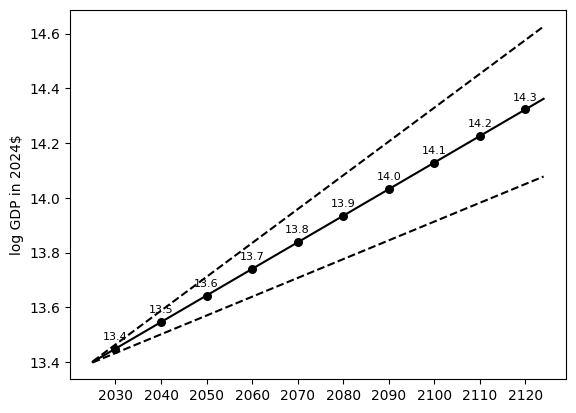

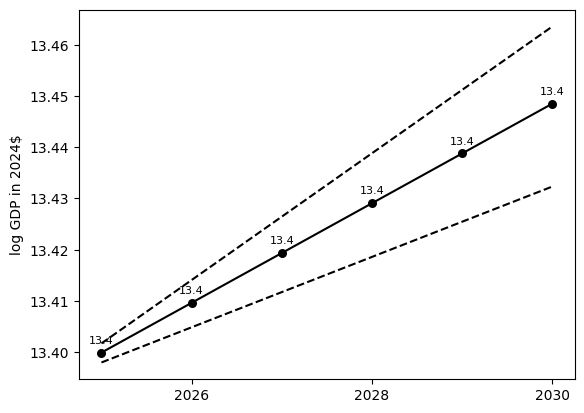



## Willingness to Pay Over Time (Total infrastructure) ##
Year: 2025 - willingness log 2024$USD per year for total infrastructure 10.4 (~27.9 billion) 80% CI 9.8 (~6.0 billion) - 11.3 (~189.6 billion)
Year: 2026 - willingness log 2024$USD per year for total infrastructure 10.7 (~51.0 billion) 80% CI 10.1 (~11.9 billion) - 11.5 (~294.7 billion)
Year: 2027 - willingness log 2024$USD per year for total infrastructure 10.9 (~86.3 billion) 80% CI 10.3 (~18.4 billion) - 11.7 (~451.1 billion)
Year: 2028 - willingness log 2024$USD per year for total infrastructure 11.1 (~131.8 billion) 80% CI 10.4 (~23.0 billion) - 11.8 (~675.4 billion)
Year: 2029 - willingness log 2024$USD per year for total infrastructure 11.3 (~179.4 billion) 80% CI 10.4 (~25.5 billion) - 12.0 (~981.6 billion)
Year: 2030 - willingness log 2024$USD per year for total infrastructure 11.3 (~220.2 billion) 80% CI 10.4 (~26.8 billion) - 12.1 (~1.4 trillion)
Year: 2031 - willingness log 2024$USD per year for total infrastructur

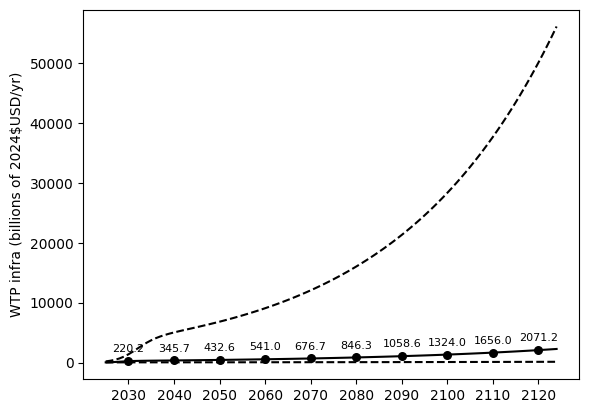

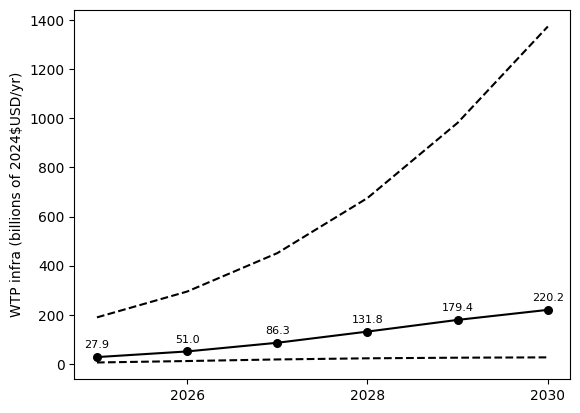



## Willingness to Pay Over Time (Largest single model) ##
Year: 2025 - willingness log 2024$USD per year for largest single model 9.0 (~1.1 billion) 80% CI 8.8 (~604.5 million) - 9.4 (~2.4 billion)
Year: 2026 - willingness log 2024$USD per year for largest single model 9.3 (~2.0 billion) 80% CI 9.1 (~1.2 billion) - 9.6 (~3.7 billion)
Year: 2027 - willingness log 2024$USD per year for largest single model 9.5 (~3.5 billion) 80% CI 9.3 (~1.8 billion) - 9.8 (~5.6 billion)
Year: 2028 - willingness log 2024$USD per year for largest single model 9.7 (~5.3 billion) 80% CI 9.4 (~2.3 billion) - 9.9 (~8.4 billion)
Year: 2029 - willingness log 2024$USD per year for largest single model 9.9 (~7.2 billion) 80% CI 9.4 (~2.6 billion) - 10.1 (~12.3 billion)
Year: 2030 - willingness log 2024$USD per year for largest single model 9.9 (~8.8 billion) 80% CI 9.4 (~2.7 billion) - 10.2 (~17.2 billion)
Year: 2031 - willingness log 2024$USD per year for largest single model 10.0 (~10.0 billion) 80% CI 9.4 (~

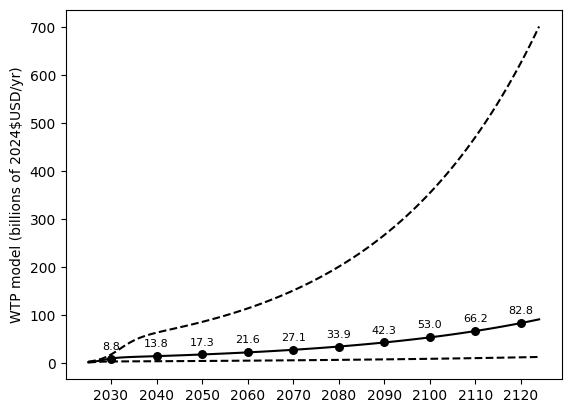

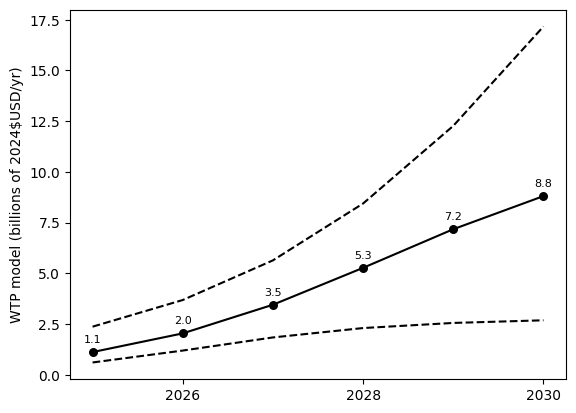



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 30.8 (~6.3 nonillion) 80% CI 26.9 (~794.3 septillion) - 36.7 (~5.0 thousand decillion)
Year: 2026 - logFLOP needed for TAI 30.5 (~3.2 nonillion) 80% CI 26.5 (~345.9 septillion) - 36.5 (~3.1 thousand decillion)
Year: 2027 - logFLOP needed for TAI 30.2 (~1.6 nonillion) 80% CI 26.2 (~151.7 septillion) - 36.3 (~1.9 thousand decillion)
Year: 2028 - logFLOP needed for TAI 29.9 (~851.7 octillion) 80% CI 25.8 (~69.1 septillion) - 36.1 (~1.2 thousand decillion)
Year: 2029 - logFLOP needed for TAI 29.7 (~457.4 octillion) 80% CI 25.5 (~34.0 septillion) - 35.9 (~708.7 decillion)
Year: 2030 - logFLOP needed for TAI 29.4 (~260.2 octillion) 80% CI 25.3 (~19.0 septillion) - 35.6 (~435.8 decillion)
Year: 2031 - logFLOP needed for TAI 29.2 (~161.6 octillion) 80% CI 25.1 (~12.7 septillion) - 35.4 (~268.7 decillion)
Year: 2032 - logFLOP needed for TAI 29.1 (~112.4 octillion) 80% CI 25.0 (~9.9 septillion

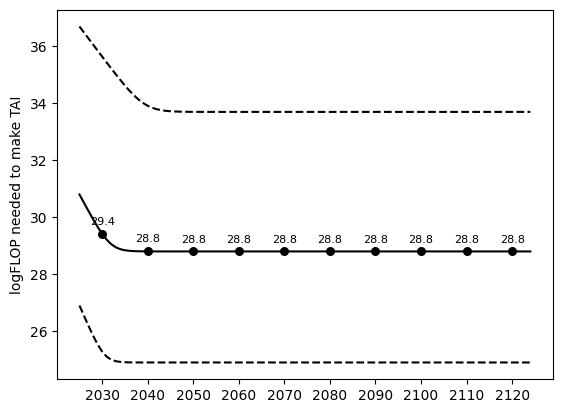

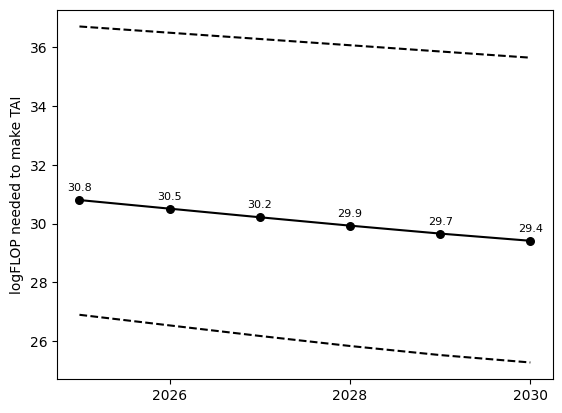



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.3 (~1.9 quintillion) 80% CI 17.9 (~803.5 quadrillion) - 18.7 (~5.0 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.4 (~2.6 quintillion) 80% CI 18.0 (~1.1 quintillion) - 18.8 (~6.4 quintillion)
Year: 2027 - logFLOP per 2024$1USD 18.5 (~3.4 quintillion) 80% CI 18.2 (~1.5 quintillion) - 18.9 (~8.2 quintillion)
Year: 2028 - logFLOP per 2024$1USD 18.7 (~4.5 quintillion) 80% CI 18.3 (~2.0 quintillion) - 19.0 (~10.6 quintillion)
Year: 2029 - logFLOP per 2024$1USD 18.8 (~5.9 quintillion) 80% CI 18.4 (~2.8 quintillion) - 19.1 (~13.6 quintillion)
Year: 2030 - logFLOP per 2024$1USD 18.9 (~7.9 quintillion) 80% CI 18.6 (~3.8 quintillion) - 19.2 (~17.6 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.0 (~10.4 quintillion) 80% CI 18.7 (~5.2 quintillion) - 19.4 (~22.6 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.1 (~13.7 quintillion) 80% CI 18.8 (~7.1 quintillion) - 19.5 (~29.1 quintillion)
Year: 2033 - lo

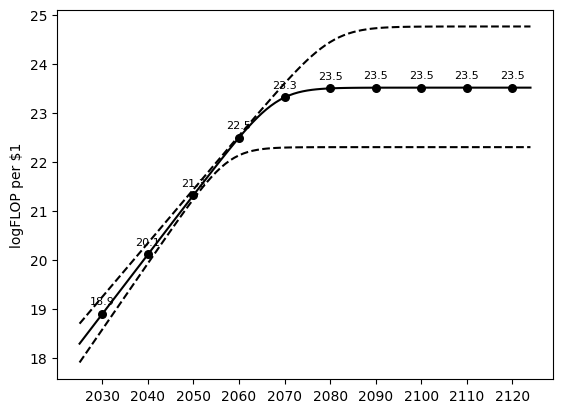

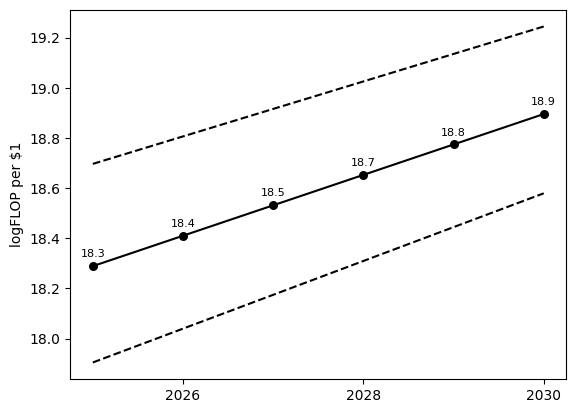



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

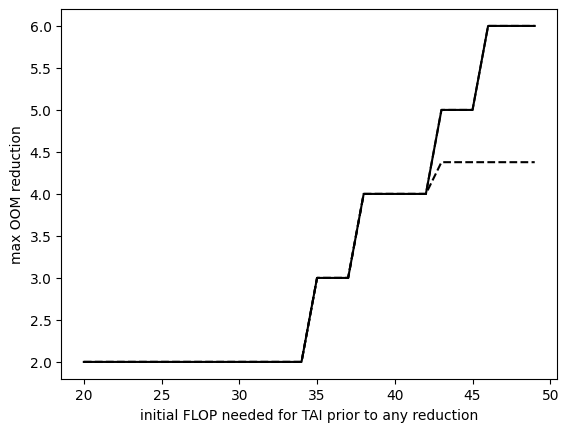



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 21 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 22 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 23 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 24 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 25 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 26 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 27 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 28 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 29 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 30 -> algo doubling rate 1.28yrs (80% CI: 2.01 to 2.01)
TAI log FLOP 31 -> algo doubling rate 1.0yrs (80% CI: 1.51 to 1.51)
TAI log FLOP 32 -> algo doubling rate 1.0yrs (80% CI: 1.01 to 1.01)
TAI log FLOP 33 -> algo doubling rate 1.0yrs (80% CI

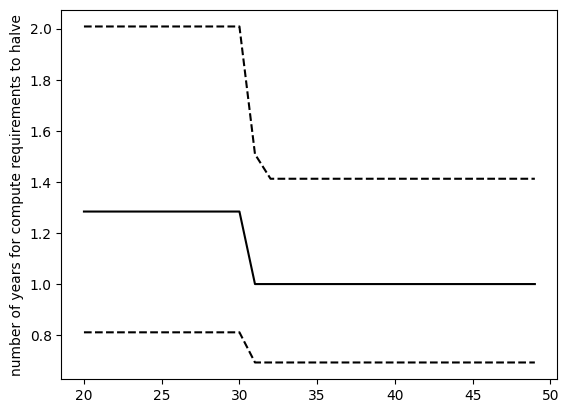



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 12.5 log 2024$USD to buy TAI (~3.2 trillion) 80% CI 9.0 (~988.6 million) - 18.0 (~1.0 quintillion)
Year: 2026 - 12.1 log 2024$USD to buy TAI (~1.3 trillion) 80% CI 8.5 (~315.5 million) - 17.7 (~480.0 quadrillion)
Year: 2027 - 11.7 log 2024$USD to buy TAI (~482.3 billion) 80% CI 8.0 (~101.4 million) - 17.4 (~228.5 quadrillion)
Year: 2028 - 11.3 log 2024$USD to buy TAI (~189.4 billion) 80% CI 7.5 (~33.9 million) - 17.0 (~108.9 quadrillion)
Year: 2029 - 10.9 log 2024$USD to buy TAI (~76.9 billion) 80% CI 7.1 (~12.2 million) - 16.7 (~51.9 quadrillion)
Year: 2030 - 10.5 log 2024$USD to buy TAI (~33.1 billion) 80% CI 6.7 (~5.0 million) - 16.4 (~24.8 quadrillion)
Year: 2031 - 10.2 log 2024$USD to buy TAI (~15.6 billion) 80% CI 6.4 (~2.4 million) - 16.1 (~11.9 quadrillion)
Year: 2032 - 9.9 log 2024$USD to buy TAI (~8.2 billion) 80% CI 6.1 (~1.4 million) - 15.8 (~5.7 quadrillion)
Year: 2033 

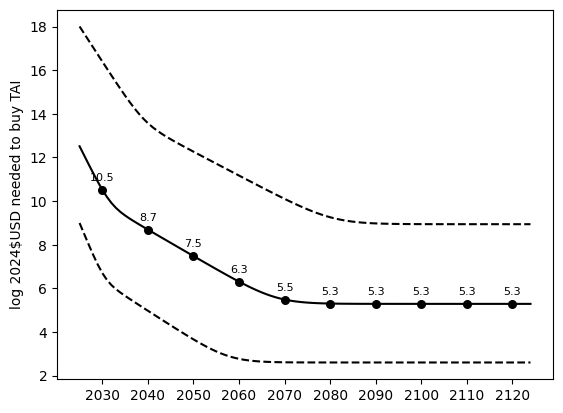

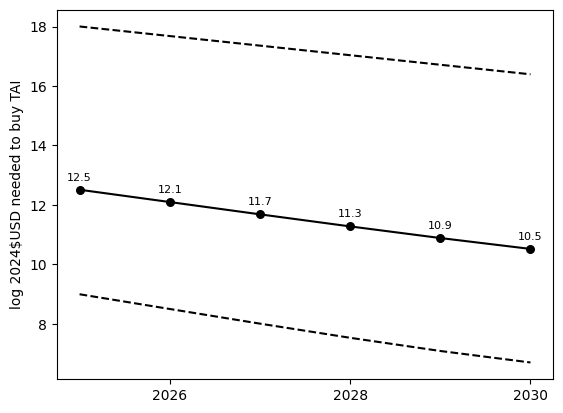



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.3 (~2.2 octillion) 80% CI 26.7 (~485.7 septillion) - 28.1 (~11.8 octillion)
Year: 2026 - max log FLOP 27.7 (~5.2 octillion) 80% CI 27.1 (~1.3 octillion) - 28.4 (~23.6 octillion)
Year: 2027 - max log FLOP 28.1 (~11.7 octillion) 80% CI 27.4 (~2.8 octillion) - 28.7 (~46.5 octillion)
Year: 2028 - max log FLOP 28.4 (~23.7 octillion) 80% CI 27.7 (~4.7 octillion) - 29.0 (~89.5 octillion)
Year: 2029 - max log FLOP 28.6 (~42.7 octillion) 80% CI 27.9 (~7.1 octillion) - 29.2 (~167.5 octillion)
Year: 2030 - max log FLOP 28.8 (~69.2 octillion) 80% CI 28.0 (~10.2 octillion) - 29.5 (~301.6 octillion)
Year: 2031 - max log FLOP 29.0 (~104.1 octillion) 80% CI 28.2 (~14.3 octillion) - 29.7 (~519.2 octillion)
Year: 2032 - max log FLOP 29.2 (~149.2 octillion) 80% CI 28.3 (~19.9 octillion) - 29.9 (~851.5 octillion)
Year: 2033 - max log FLOP 29.3 (~208.1 octillion) 80% CI 28.4 (~27.6 octillion) - 30.1 (~1.3 nonillion)
Year: 2034 - max log FLOP 29.

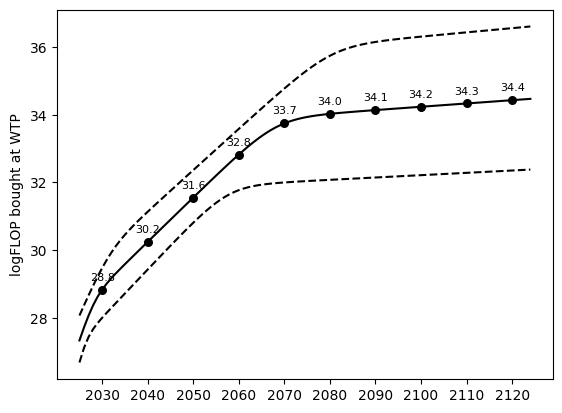

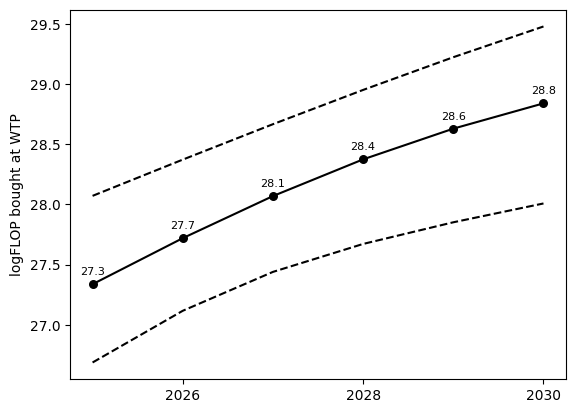



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.3 (~2.2 octillion) 80% CI 26.7 (~485.7 septillion) - 28.1 (~11.8 octillion)
Year: 2026 - max log effective 2024-FLOP 28.0 (~10.3 octillion) 80% CI 27.3 (~2.1 octillion) - 28.8 (~64.0 octillion)
Year: 2027 - max log effective 2024-FLOP 28.7 (~45.2 octillion) 80% CI 27.9 (~7.1 octillion) - 29.5 (~341.0 octillion)
Year: 2028 - max log effective 2024-FLOP 29.2 (~175.6 octillion) 80% CI 28.3 (~19.6 octillion) - 30.2 (~1.8 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.8 (~588.5 octillion) 80% CI 28.7 (~47.3 octillion) - 30.9 (~8.7 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.2 (~1.7 nonillion) 80% CI 29.0 (~106.2 octillion) - 31.6 (~39.0 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.6 (~4.1 nonillion) 80% CI 29.4 (~228.5 octillion) - 32.2 (~149.5 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.9 (~8.4 nonillion) 80% CI 29.7

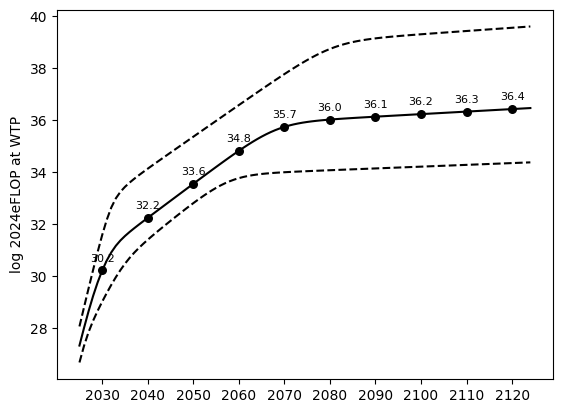

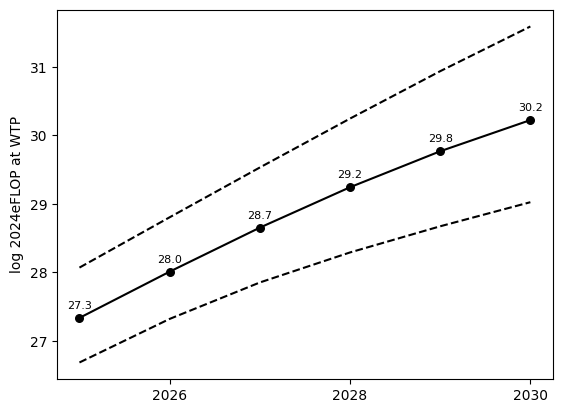


## TAI FLOP SIZE ##
{1: 24.1,
 5: 25.3,
 10: 26.1,
 20: 26.9,
 30: 27.7,
 40: 29.26,
 50: 30.8,
 60: 32.8,
 70: 34.6,
 80: 36.7,
 90: 40.010000000000005,
 95: 42.904999999999994,
 99: 48.501999999999995}


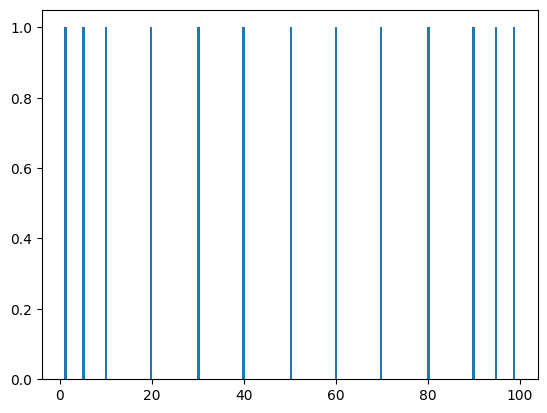



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.0546007118118887,
 5: 2.874979647102067,
 10: 3.5779020395198446,
 20: 4.377810141838066,
 30: 5.092305209092964,
 40: 5.869808497904097,
 50: 6.599324723230551,
 60: 7.428729148517779,
 70: 8.683798576645357,
 80: 10.13440874763763,
 90: 12.357084450202182,
 95: 14.917968066428752,
 99: 19.975656917887292}


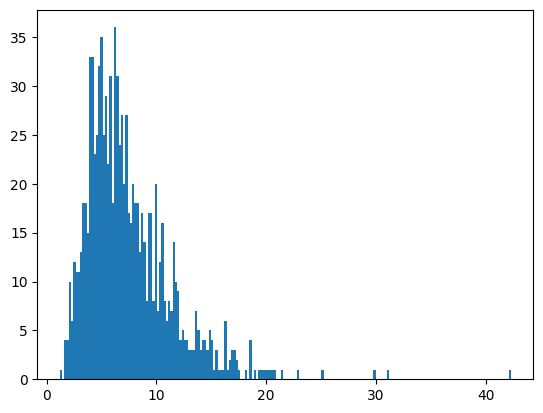



## MIN ALGO DOUBLING RATE ##
{1: 0.3757525810524436,
 5: 0.47983816397594,
 10: 0.567478672679629,
 20: 0.6928868590997792,
 30: 0.8116527328726444,
 40: 0.9026010920958587,
 50: 0.9999159901174239,
 60: 1.1193721684697708,
 70: 1.2536532572485122,
 80: 1.4122502365771838,
 90: 1.7267583908613966,
 95: 2.065441189650533,
 99: 2.826920789838051}


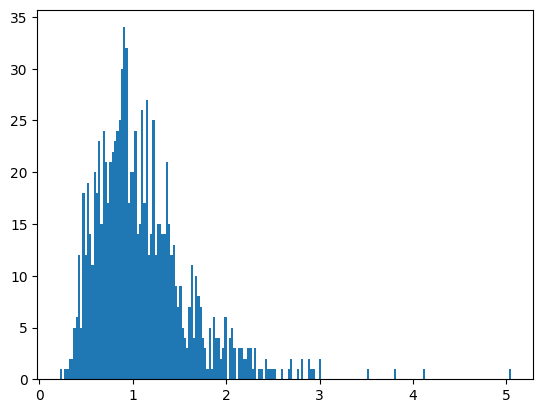



## MAX ALGO DOUBLING RATE ##
{1: 0.36855889354542604,
 5: 0.5129635980098778,
 10: 0.6378276466910604,
 20: 0.8109582798389512,
 30: 0.9506799944001657,
 40: 1.1418971073421653,
 50: 1.2838699078627336,
 60: 1.4538281613530388,
 70: 1.6803208870510207,
 80: 2.00848669922479,
 90: 2.5927816903123087,
 95: 3.090751674328612,
 99: 4.277709883536118}


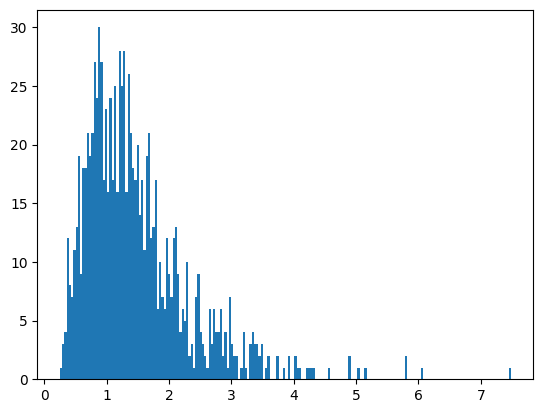



## INITIAL FLOP PER DOLLAR ##
{1: 17.19961068661282,
 5: 17.491354477868004,
 10: 17.66315080004865,
 20: 17.905004793210804,
 30: 18.042385667454656,
 40: 18.185373631178944,
 50: 18.289054626564806,
 60: 18.423319915363486,
 70: 18.55621642600717,
 80: 18.696776289932608,
 90: 18.910555848870054,
 95: 19.079720470129196,
 99: 19.469787526959202}


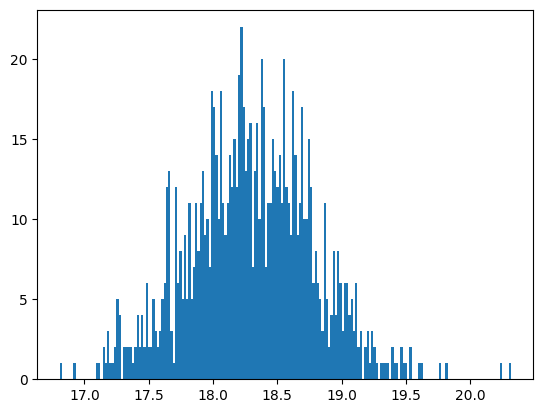



## FLOP HALVING RATE ##
{1: 1.7193943675568597,
 5: 1.9977841131126712,
 10: 2.099154542878757,
 20: 2.231399028286625,
 30: 2.334090306611207,
 40: 2.4114047230826605,
 50: 2.481870216750761,
 60: 2.5602791400435074,
 70: 2.6546553761404317,
 80: 2.7472560735440554,
 90: 2.898552467393076,
 95: 3.002548563163812,
 99: 3.2053263707522786}


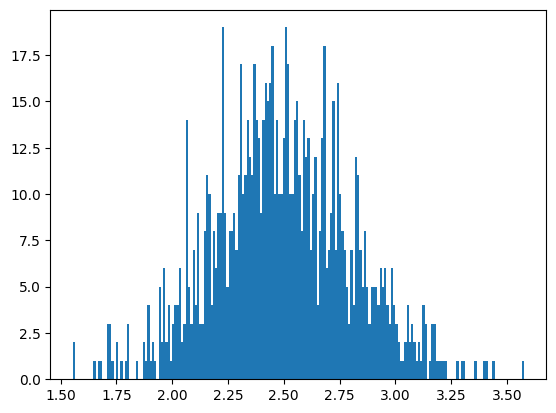



## MAX FLOP PER DOLLAR ##
{1: 20.16464820686648,
 5: 21.066446212071718,
 10: 21.61757137316747,
 20: 22.298039122062754,
 30: 22.692575949895588,
 40: 23.092463930413437,
 50: 23.511755695056383,
 60: 23.93529442150728,
 70: 24.33805430865586,
 80: 24.75957102670598,
 90: 25.54784237014723,
 95: 26.236412972626415,
 99: 27.453530417470528}


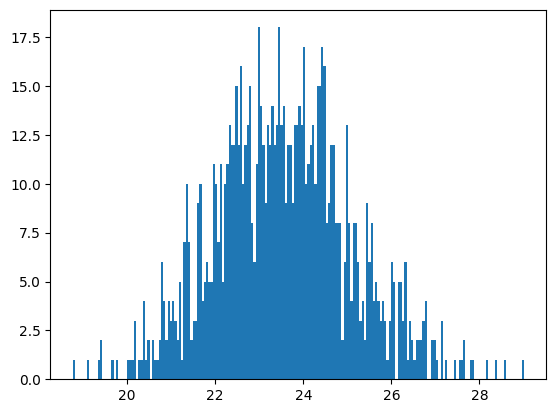



## INITIAL PAY ##
{1: 8.5,
 5: 8.6,
 10: 8.7,
 20: 8.9,
 30: 8.9,
 40: 9.0,
 50: 9.1,
 60: 9.2,
 70: 9.3,
 80: 9.4,
 90: 9.6,
 95: 9.8,
 99: 10.2}


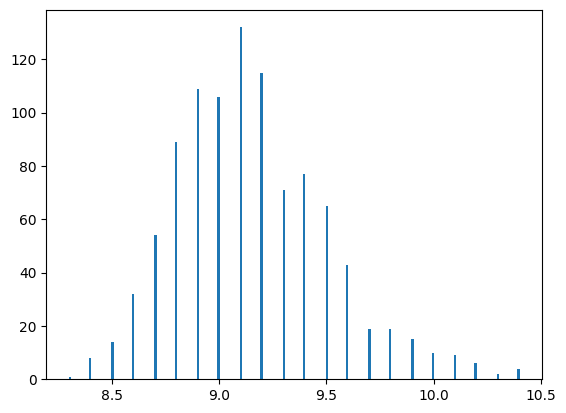



## INITIAL GDP ##
{1: 24824819658904.508,
 5: 24887342609366.98,
 10: 24955298068679.08,
 20: 25003075767682.86,
 30: 25045244410209.785,
 40: 25079853692142.5,
 50: 25114318721679.11,
 60: 25147005320283.184,
 70: 25181231934433.074,
 80: 25218295865601.043,
 90: 25277180368864.58,
 95: 25327162773598.395,
 99: 25401538535550.703}


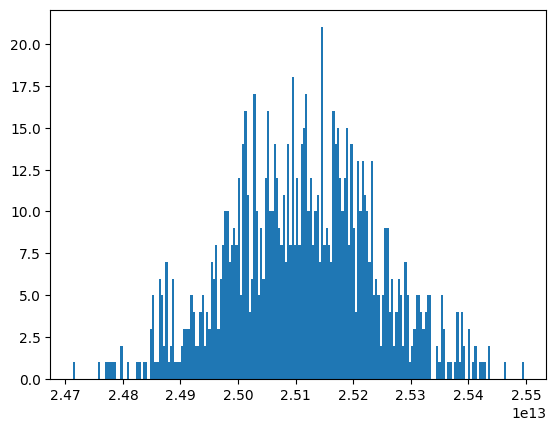



## GDP GROWTH ##
{1: 1.0052464475080551,
 5: 1.010307308669016,
 10: 1.013274394516896,
 20: 1.0159384058593093,
 30: 1.018359253303604,
 40: 1.0207424995572905,
 50: 1.0226261804654175,
 60: 1.0244869099857248,
 70: 1.0264902101825362,
 80: 1.028891777134677,
 90: 1.032408029446347,
 95: 1.034903663099833,
 99: 1.041737550057639}


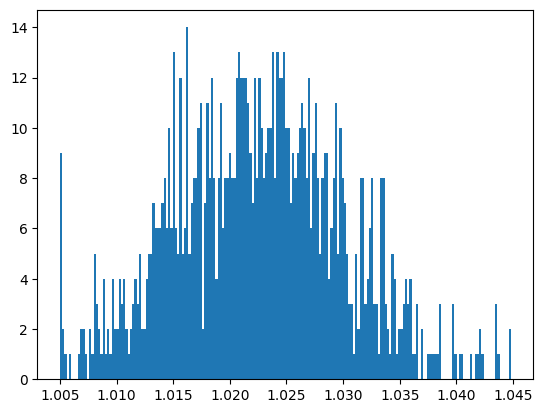



## MAX GDP FRAC ##
{1: 1.7338059505760998e-05,
 5: 3.243573951028848e-05,
 10: 5.4944466392810705e-05,
 20: 0.00010117877857404856,
 30: 0.00017215229673601528,
 40: 0.0002652460385881905,
 50: 0.0003937824265062801,
 60: 0.0006079505535611962,
 70: 0.0009692327601910409,
 80: 0.0016589318151982533,
 90: 0.002940351309830479,
 95: 0.005401014596539993,
 99: 0.01276178482415749}


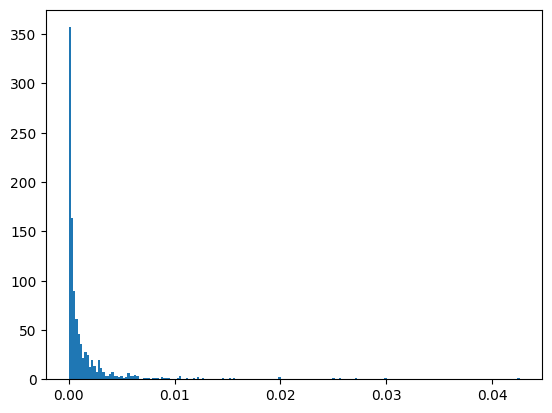



## SPEND DOUBLING TIME ##
{1: 0.383005942986451,
 5: 0.48718103675968394,
 10: 0.5572714533307322,
 20: 0.6736687983193052,
 30: 0.7694552603663579,
 40: 0.8700336988757004,
 50: 0.9800522512906711,
 60: 1.1001832751730387,
 70: 1.2654179305087498,
 80: 1.4673493295931692,
 90: 1.7354355382356557,
 95: 2.0220994286848137,
 99: 2.653707731807695}


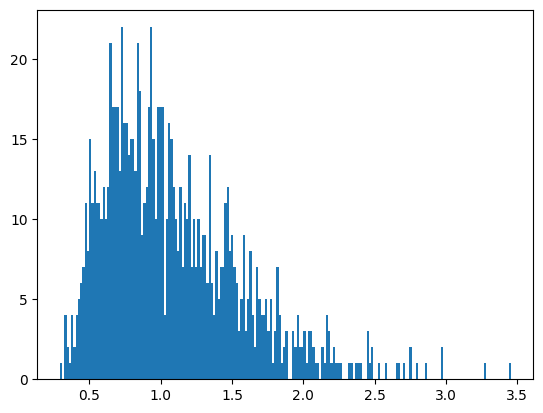





## Nonscaling delay ##
There are 3 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 1,
 5: 1,
 10: 1,
 20: 2,
 30: 2,
 40: 2,
 50: 2,
 60: 3,
 70: 3,
 80: 4,
 90: 5,
 95: 7,
 99: 16}
## Chance of nonscaling delay ##


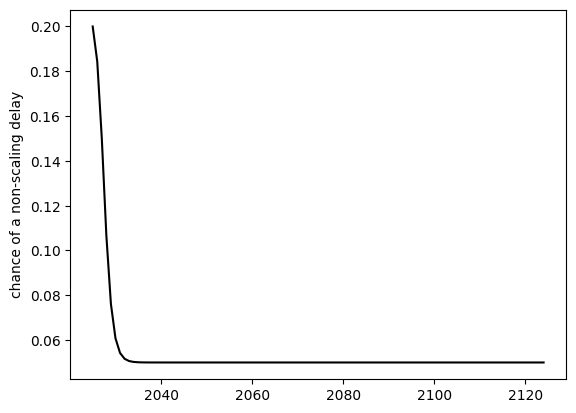

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - cha

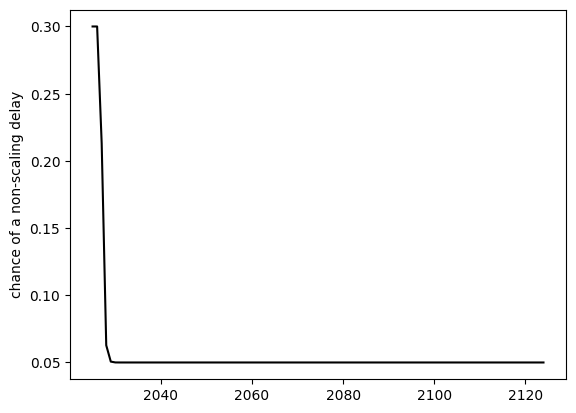

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - chan

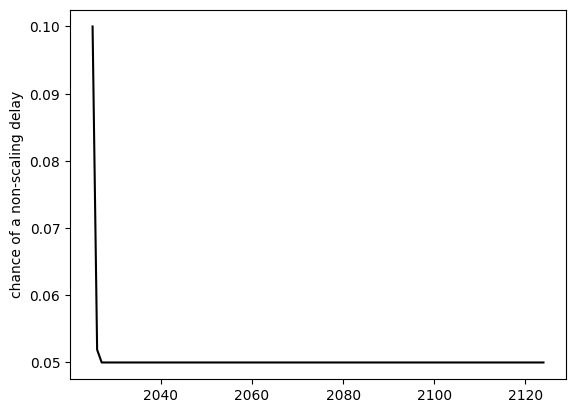

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - chance

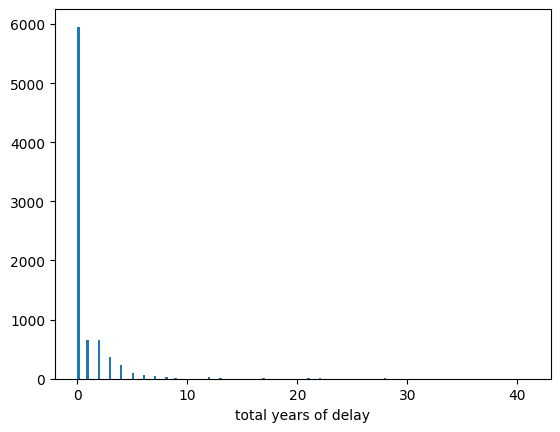

In [15]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=max(1, os.cpu_count() - 2),
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 30.1 log FLOP (~1.3 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~626.8 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~426.2 quintillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 0.5 year to a max of 0.142433% of GDP (initially ~35.8 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 30.1 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 9.1 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 29.8 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.6 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 29.5 logFLOP which costs 11.5 log 2025$USD to buy vs. WTP at 10.0 (buys 28.1 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 29.2 logFLOP which cos

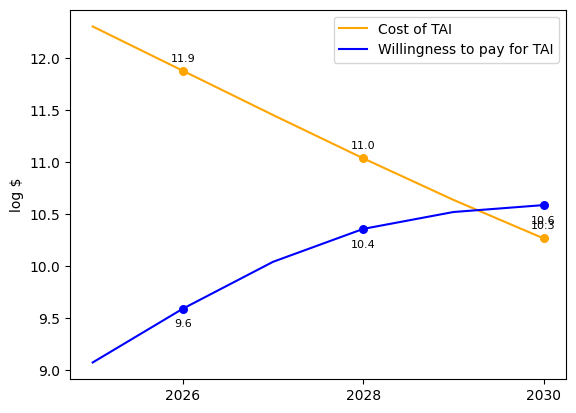

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~100.3 septillion) per 2025$USD.
* We are initially willing to pay 10.1 log 2025$USD (~14.0 billion).
* This doubles every 1.4 year to a max of 0.185241% of GDP (initially ~46.5 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 26.4 logFLOP which costs 7.8 log 2025$USD to buy vs. WTP at 10.0 (buys 28.7 log FLOP or 28.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 

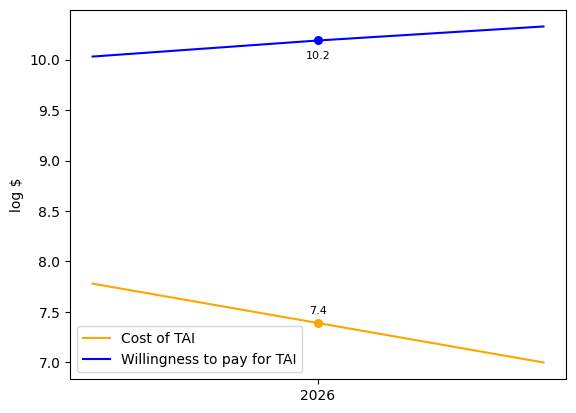

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 33.9 log FLOP (~7.9 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.1 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1.5 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.4 billion).
* This doubles every 0.7 year to a max of 0.172554% of GDP (initially ~43.5 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 33.9 logFLOP which costs 14.8 log 2025$USD to buy vs. WTP at 9.4 (buys 28.4 log FLOP or 28.4 2025-log-eFLOP)
2026 - TAI takes 33.5 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 9.7 (buys 28.9 log FLOP or 29.4 2025-log-eFLOP)
2027 - TAI takes 33.1 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 10.1 (buys 29.4 log FLOP or 30.2 2025-log-eFLOP)
2028 - TAI takes 32.7 logFLOP which costs 13

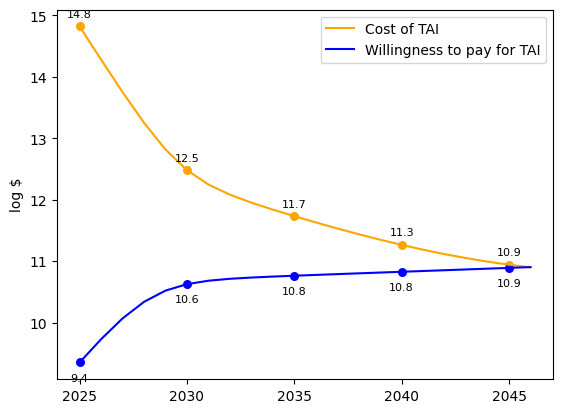

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 43.3 log FLOP (~20.0 billion decillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 4.2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.8 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~328.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~199.0 million).
* This doubles every 1.2 year to a max of 0.29351% of GDP (initially ~72.9 billion 2025$USD).
* GDP grows at a rate of 1.039x per year.
---
2025 - TAI takes 43.3 logFLOP which costs 25.1 log 2025$USD to buy vs. WTP at 8.3 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 43.1 logFLOP which costs 24.7 log 2025$USD to buy vs. WTP at 8.5 (buys 26.9 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 42.8 logFLOP which costs 24.3 log 2025$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 42.6 logFLOP w

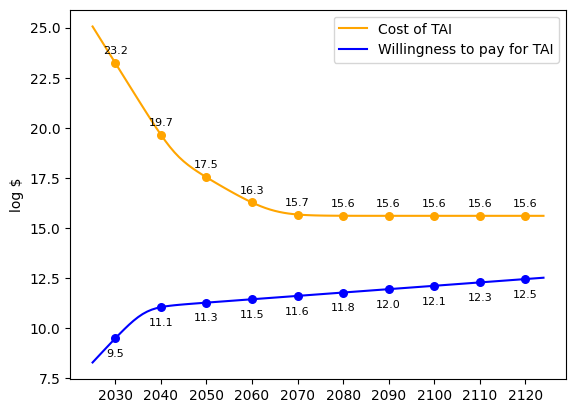

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 30.8 log FLOP (~6.3 nonillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.6 log FLOP (~361.2 quadrillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~13.4 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~980.8 million).
* This doubles every 1.0 year to a max of 0.205074% of GDP (initially ~51.1 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 30.8 logFLOP which costs 13.2 log 2025$USD to buy vs. WTP at 9.0 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 30.5 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 9.3 (buys 27.0 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 30.2 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 9.6 (buys 27.4 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 29.9 logFLOP which cost

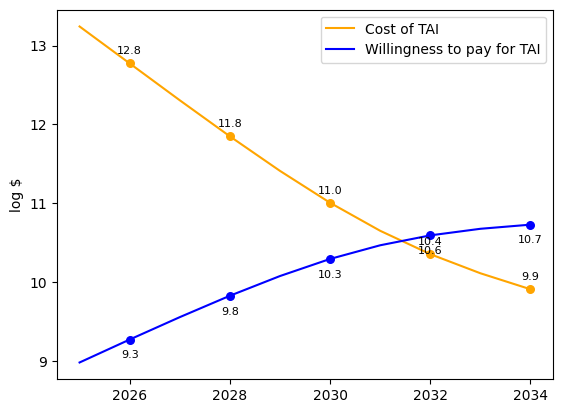

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 35.9 log FLOP (~794.3 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.7 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~93.2 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 1.2 year to a max of 0.210364% of GDP (initially ~53.1 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 35.9 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 35.6 logFLOP which costs 17.0 log 2025$USD to buy vs. WTP at 9.5 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 35.3 logFLOP which costs 16.6 log 2025$USD to buy vs. WTP at 9.8 (buys 28.5 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 35.0 logFLOP which costs 

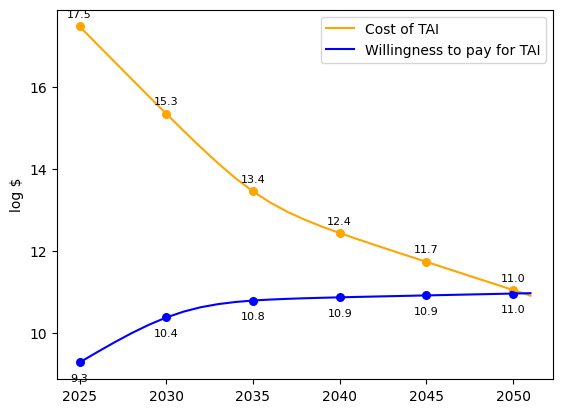

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 27.5 log FLOP (~3.2 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 1.8 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~159.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.1 year to a max of 0.011584% of GDP (initially ~2.9 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 27.5 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 27.3 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 9.1 (buys 27.4 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1843 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- data p_nonscaling_issue 

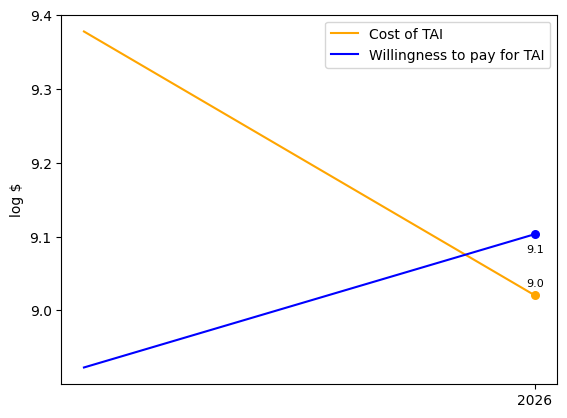

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~33.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.1 billion).
* This doubles every 1.6 year to a max of 0.015823% of GDP (initially ~4.0 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 2 more 

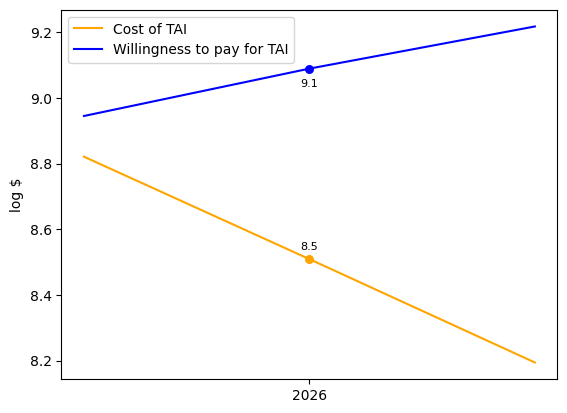

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 30.7 log FLOP (~5.0 nonillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~736.3 quadrillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~622.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~463.9 million).
* This doubles every 0.6 year to a max of 0.024766% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 30.7 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 8.6 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 30.4 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 9.1 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 30.2 logFLOP which costs 12.1 log 2025$USD to buy vs. WTP at 9.5 (buys 27.5 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 29.9 logFLOP which cos

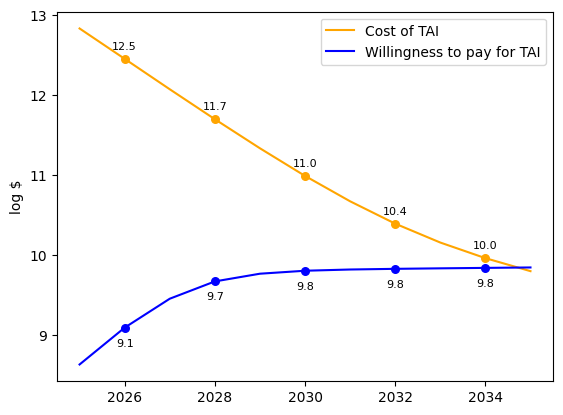

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 28.0 log FLOP (~10.0 octillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.4 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 27.3 log FLOP (~2.2 octillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.3 billion).
* This doubles every 1.1 year to a max of 0.101151% of GDP (initially ~25.3 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 28.0 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 27.8 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 9.6 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1843 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 1 years)
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issu

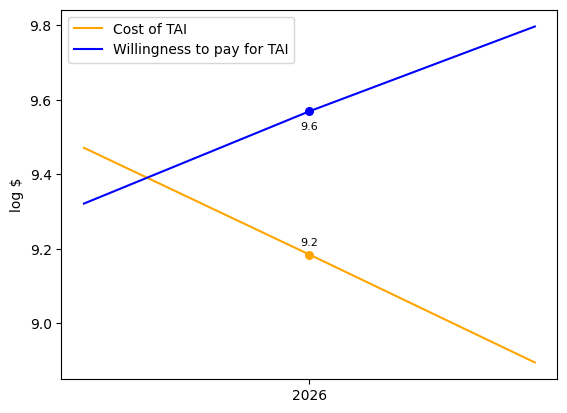

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 25.3 log FLOP (~20.0 septillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~48.6 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~625.0 million).
* This doubles every 1.0 year to a max of 0.261188% of GDP (initially ~66.2 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 25.3 logFLOP which costs 6.8 log 2025$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 4 

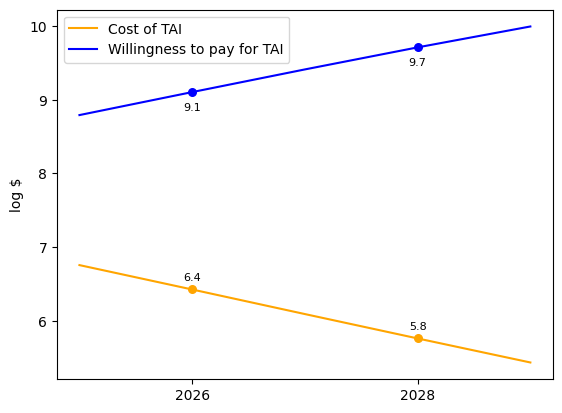

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 31.9 log FLOP (~79.4 nonillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 20.4 log FLOP (~272.9 quintillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 0.6 year to a max of 0.021972% of GDP (initially ~5.5 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 31.9 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 8.9 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 31.7 logFLOP which costs 13.4 log 2025$USD to buy vs. WTP at 9.3 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 31.5 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.6 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 31.3 logFLOP which costs

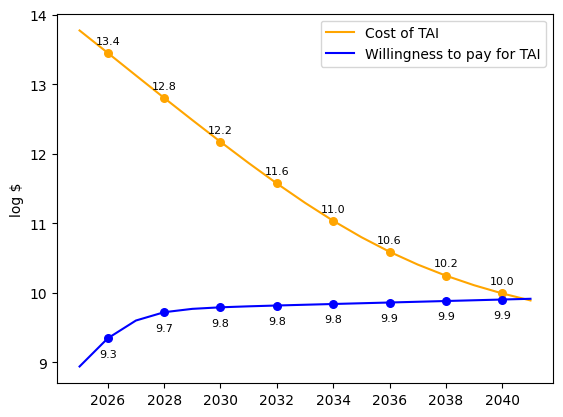

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 28.4 log FLOP (~25.1 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~744.0 quadrillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~601.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~2.1 billion).
* This doubles every 0.8 year to a max of 0.05155% of GDP (initially ~12.9 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 28.4 logFLOP which costs 10.5 log 2025$USD to buy vs. WTP at 9.3 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 28.3 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 9.6 (buys 27.6 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 28.1 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 9.8 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 28.0 logFLOP which cost

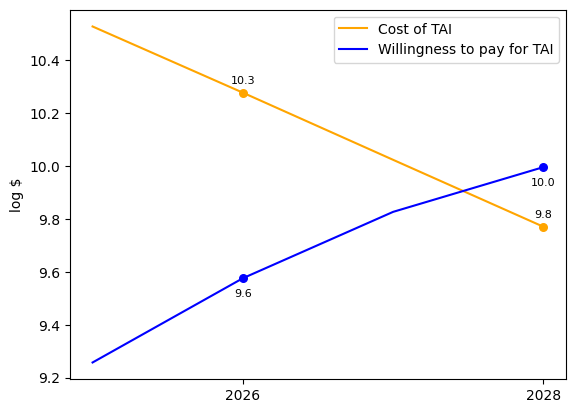

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.5 log FLOP (~325.3 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~14.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~4.9 billion).
* This doubles every 1.0 year to a max of 0.051162% of GDP (initially ~12.7 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 9.5 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not occur
--- /!\ TAI CREATED in 2025
-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 

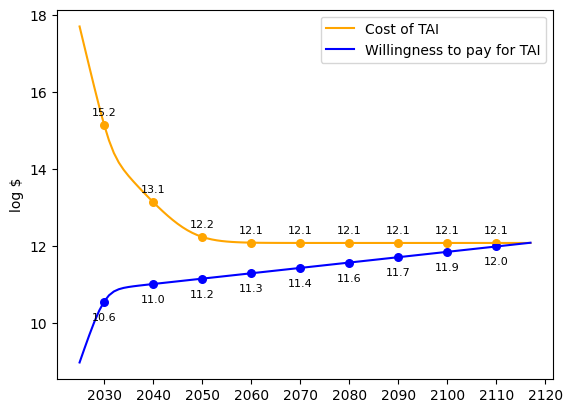

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 26.1 log FLOP (~125.9 septillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.1 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~37.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~576.0 million).
* This doubles every 0.7 year to a max of 0.005459% of GDP (initially ~1.4 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 26.1 logFLOP which costs 7.6 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not occur
--- /!\ TAI CREATED in 2025
-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 

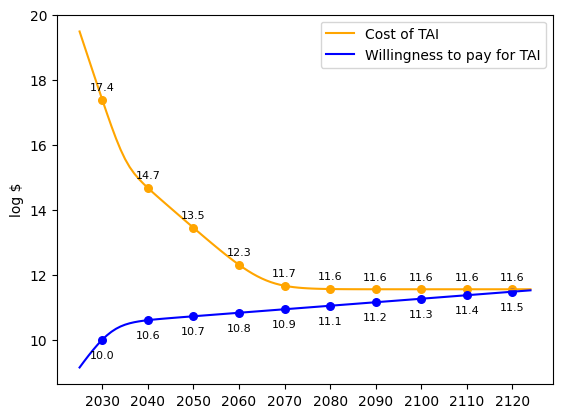

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 40.0 log FLOP (~10.0 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.4 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.1 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~711.1 million).
* This doubles every 1.7 year to a max of 0.006474% of GDP (initially ~1.6 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 40.0 logFLOP which costs 21.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 39.6 logFLOP which costs 20.8 log 2025$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 39.2 logFLOP which costs 20.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 38.8 logFLOP whic

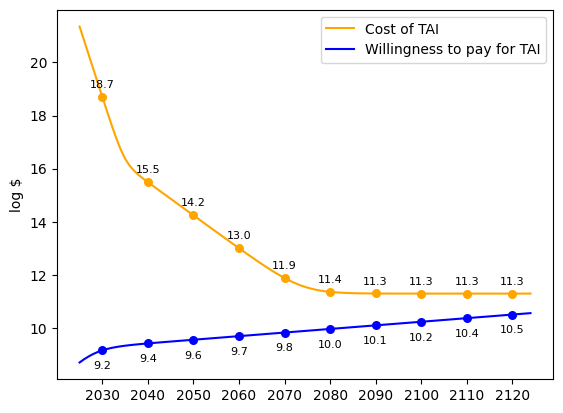

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 32.9 log FLOP (~794.3 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~567.7 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 25.3 log FLOP (~20.1 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~975.7 million).
* This doubles every 0.9 year to a max of 0.017232% of GDP (initially ~4.3 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 32.9 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 8.9 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 32.6 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 9.2 (buys 27.0 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 32.3 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 9.4 (buys 27.3 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 32.0 logFLOP which co

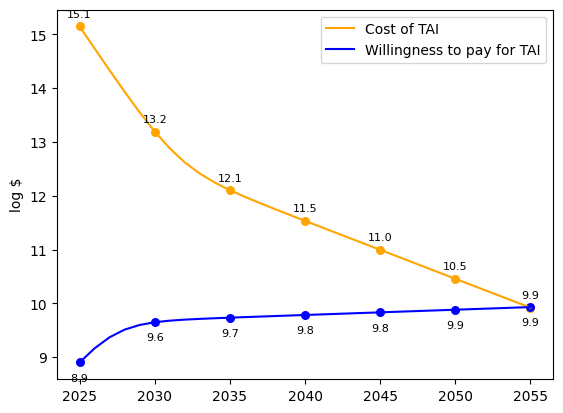

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 34.2 log FLOP (~15.8 decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~33.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~632.8 million).
* This doubles every 0.6 year to a max of 0.012422% of GDP (initially ~3.1 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 34.2 logFLOP which costs 16.1 log 2025$USD to buy vs. WTP at 8.7 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 33.8 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 33.4 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 33.1 logFLOP which costs

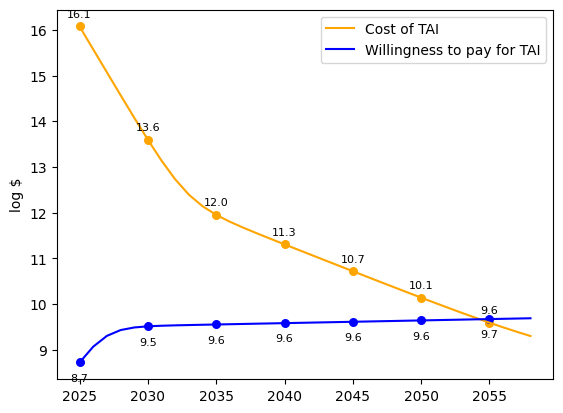

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 30.4 log FLOP (~2.5 nonillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~88.8 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~380.8 million).
* This doubles every 0.5 year to a max of 0.002465% of GDP (initially ~615.0 million 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 30.4 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 8.4 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 30.2 logFLOP which costs 11.7 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 30.1 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 8.8 (buys 27.4 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 29.9 logFLOP which cost

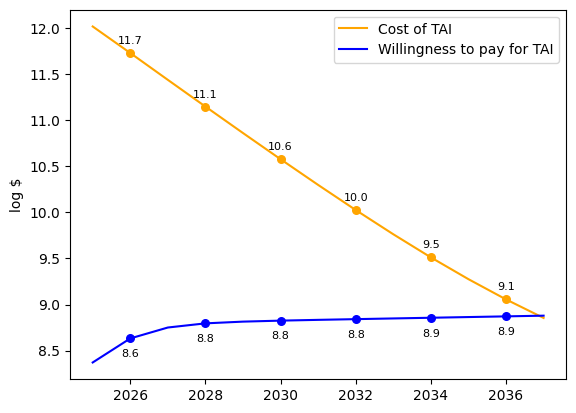

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 47.4 log FLOP (~251.2 trillion decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 6 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~535.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~351.9 million).
* This doubles every 1.5 year to a max of 0.001559% of GDP (initially ~386.0 million 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 47.4 logFLOP which costs 29.1 log 2025$USD to buy vs. WTP at 8.3 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 47.0 logFLOP which costs 28.5 log 2025$USD to buy vs. WTP at 8.4 (buys 26.8 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 46.6 logFLOP which costs 28.0 log 2025$USD to buy vs. WTP at 8.4 (buys 27.0 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 46.2 logFLO

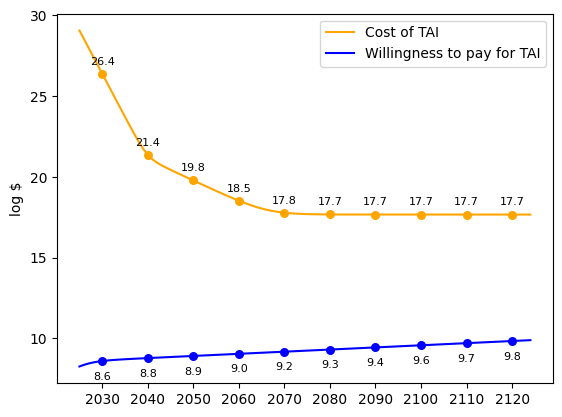

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~81.1 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.7 billion).
* This doubles every 1.1 year to a max of 0.056462% of GDP (initially ~14.2 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 10 years (total delay 10 years)
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 1

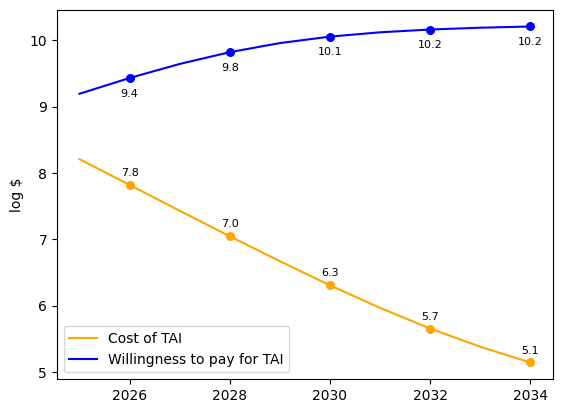

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 24.6 log FLOP (~4.0 septillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.1 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 0.9 year to a max of 0.019807% of GDP (initially ~4.9 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 24.6 logFLOP which costs 6.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not occur
--- /!\ TAI CREATED in 2025
-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 34.7 

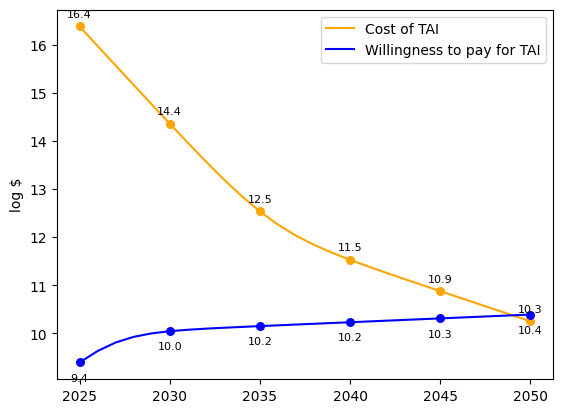

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 43.3 log FLOP (~20.0 billion decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 20.3 log FLOP (~198.8 quintillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~813.1 million).
* This doubles every 1.2 year to a max of 0.004313% of GDP (initially ~1.1 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 43.3 logFLOP which costs 25.0 log 2025$USD to buy vs. WTP at 8.7 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 42.7 logFLOP which costs 24.3 log 2025$USD to buy vs. WTP at 8.8 (buys 27.2 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 42.2 logFLOP which costs 23.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.4 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 41.6 logFLOP w

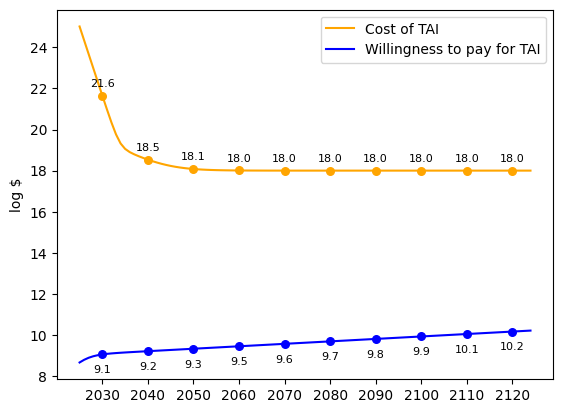

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 37.9 log FLOP (~79.4 thousand decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.5 log FLOP (~306.6 quadrillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 26.2 log FLOP (~166.1 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~723.6 million).
* This doubles every 0.9 year to a max of 0.032358% of GDP (initially ~8.1 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 37.9 logFLOP which costs 20.4 log 2025$USD to buy vs. WTP at 8.8 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
2026 - TAI takes 37.6 logFLOP which costs 20.0 log 2025$USD to buy vs. WTP at 9.1 (buys 26.7 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 37.3 logFLOP which costs 19.6 log 2025$USD to buy vs. WTP at 9.4 (buys 27.1 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 37.0 logFLOP

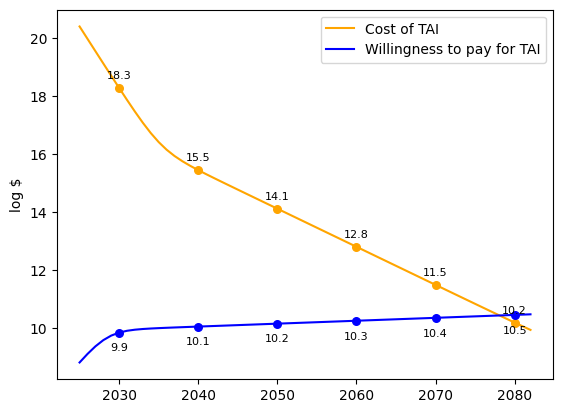

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 25.9 log FLOP (~79.4 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~100.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~962.7 million).
* This doubles every 0.8 year to a max of 0.009867% of GDP (initially ~2.5 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 25.9 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 8.8 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not occur
--- /!\ TAI CREATED in 2025
-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 

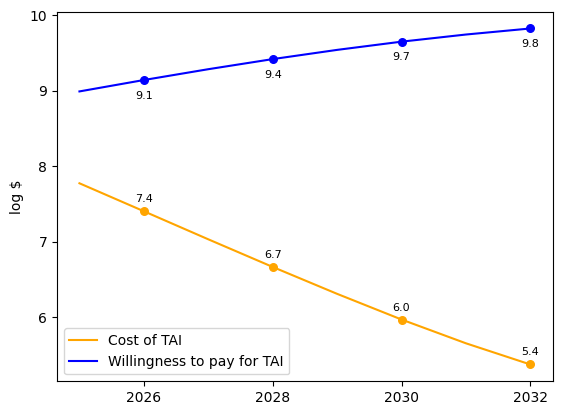

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 34.2 log FLOP (~15.8 decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~514.3 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~626.7 million).
* This doubles every 1.3 year to a max of 0.371848% of GDP (initially ~93.4 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 34.2 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 8.8 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 34.0 logFLOP which costs 16.2 log 2025$USD to buy vs. WTP at 9.0 (buys 26.9 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 33.8 logFLOP which costs 15.9 log 2025$USD to buy vs. WTP at 9.3 (buys 27.2 log FLOP or 27.6 2025-log-eFLOP)
2028 - TAI takes 33.6 logFLOP which cos

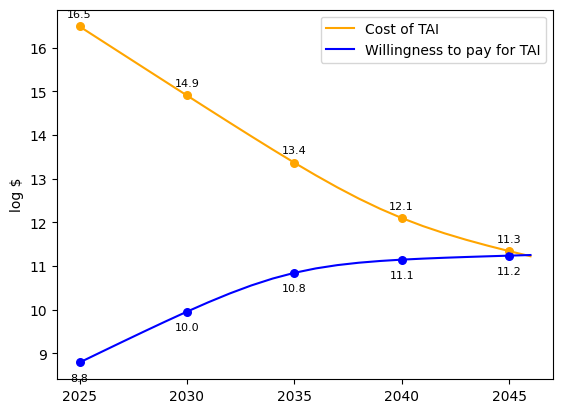

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~402.2 million).
* This doubles every 1.0 year to a max of 0.008118% of GDP (initially ~2.0 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 37.0 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 36.7 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.0 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 36.3 logFLOP which costs 18.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 36.0 logFLOP whi

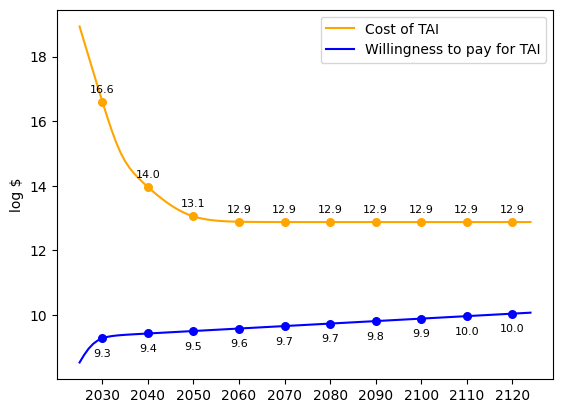

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 34.2 log FLOP (~15.8 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.7 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~142.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~471.1 million).
* This doubles every 1.1 year to a max of 0.031175% of GDP (initially ~7.8 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 34.2 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 8.6 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 33.9 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 33.6 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 33.3 logFLOP which cost

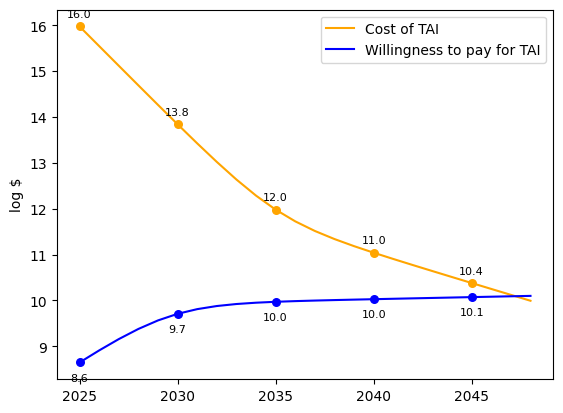

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.3 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~727.0 million).
* This doubles every 0.6 year to a max of 0.034139% of GDP (initially ~8.6 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 8.8 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 27.4 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 9.3 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1843 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- data p_nonscaling_issue 

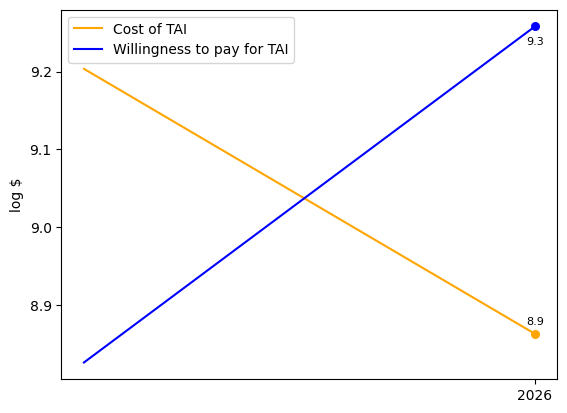

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 36.7 log FLOP (~5.0 thousand decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.4 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~186.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~216.6 million).
* This doubles every 1.0 year to a max of 0.000909% of GDP (initially ~229.0 million 2025$USD).
* GDP grows at a rate of 1.036x per year.
---
2025 - TAI takes 36.7 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 8.0 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 36.5 logFLOP which costs 17.4 log 2025$USD to buy vs. WTP at 8.2 (buys 27.2 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 36.2 logFLOP which costs 17.0 log 2025$USD to buy vs. WTP at 8.3 (buys 27.4 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 36.0 logFLOP 

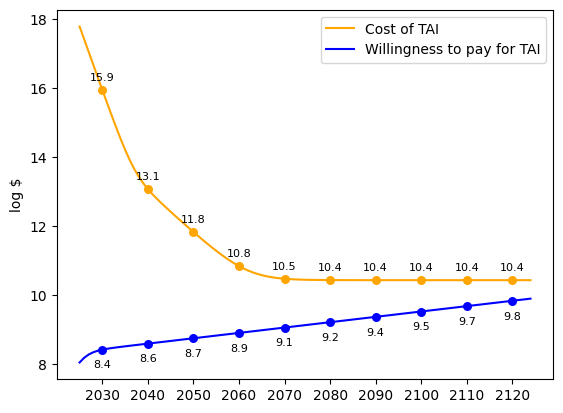

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 34.2 log FLOP (~15.8 decillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.9 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~24.2 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 0.6 year to a max of 0.013762% of GDP (initially ~3.5 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 34.2 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 34.0 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 9.3 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 33.7 logFLOP which costs 14.8 log 2025$USD to buy vs. WTP at 9.5 (buys 28.4 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 33.5 logFLOP which costs 1

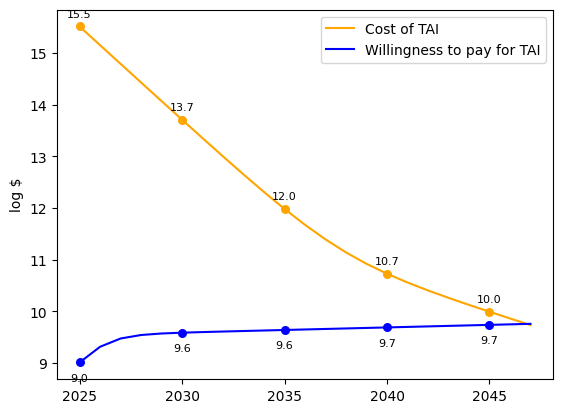

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 39.6 log FLOP (~4.0 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~228.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~627.1 million).
* This doubles every 1.9 year to a max of 0.416234% of GDP (initially ~103.6 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 39.6 logFLOP which costs 21.2 log 2025$USD to buy vs. WTP at 8.8 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 39.2 logFLOP which costs 20.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 38.8 logFLOP which costs 20.1 log 2025$USD to buy vs. WTP at 9.1 (buys 27.8 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 38.4 logFLOP w

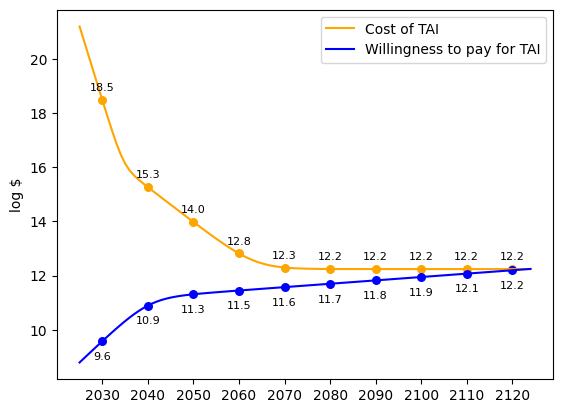

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 25.3 log FLOP (~20.0 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~459.1 quadrillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.9 year to a max of 0.502487% of GDP (initially ~125.1 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 25.3 logFLOP which costs 7.6 log 2025$USD to buy vs. WTP at 9.1 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 8 years)
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not oc

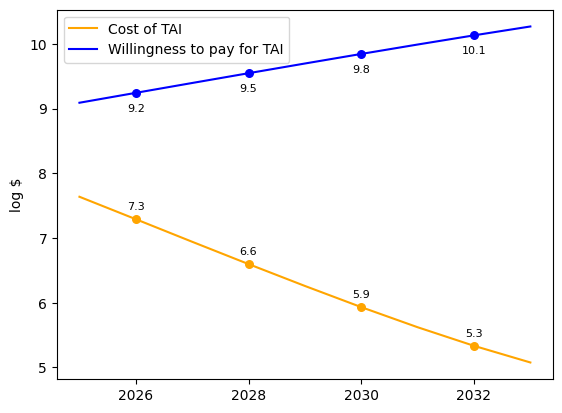

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 28.3 log FLOP (~20.0 octillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.6 log FLOP (~393.2 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~76.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.0 billion).
* This doubles every 1.2 year to a max of 0.030293% of GDP (initially ~7.6 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 28.3 logFLOP which costs 10.7 log 2025$USD to buy vs. WTP at 9.3 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 28.2 logFLOP which costs 10.5 log 2025$USD to buy vs. WTP at 9.5 (buys 27.2 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 28.1 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 9.6 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 28.0 logFLOP which costs

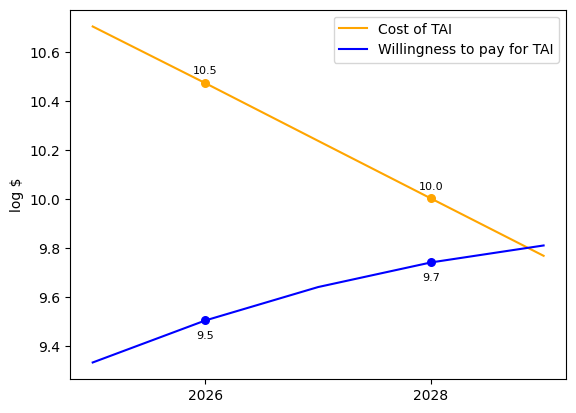

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 32.4 log FLOP (~251.2 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.3 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 0.5 year to a max of 0.01139% of GDP (initially ~2.9 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 32.4 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 32.2 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 9.2 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 31.9 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 31.7 logFLOP which costs 13

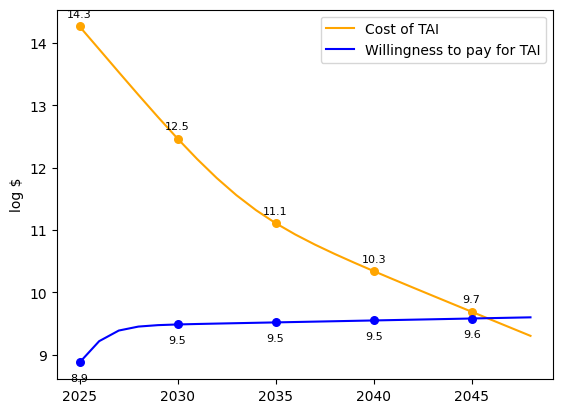

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 26.9 log FLOP (~794.3 septillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~17.4 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~978.5 million).
* This doubles every 0.6 year to a max of 0.182054% of GDP (initially ~45.5 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 26.9 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.1 -> Nonscaling issue did not occur
--- /!\ TAI CREATED in 2025
-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes

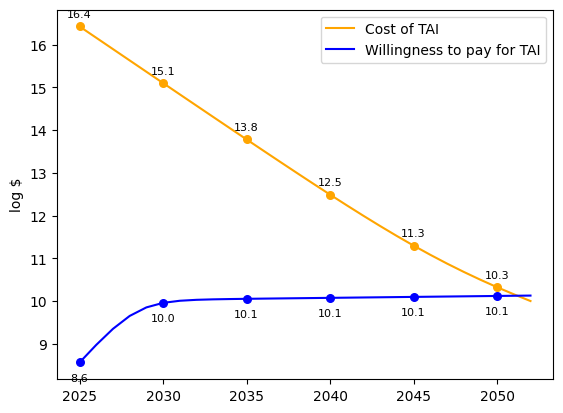

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 39.6 log FLOP (~4.0 million decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.1 quintillion) per 2025$USD.
* Every 1.8 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~251.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.4 billion).
* This doubles every 0.4 year to a max of 0.044218% of GDP (initially ~11.0 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 39.6 logFLOP which costs 20.6 log 2025$USD to buy vs. WTP at 9.1 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 39.2 logFLOP which costs 20.1 log 2025$USD to buy vs. WTP at 9.6 (buys 28.8 log FLOP or 29.1 2025-log-eFLOP)
2027 - TAI takes 38.8 logFLOP which costs 19.5 log 2025$USD to buy vs. WTP at 9.9 (buys 29.2 log FLOP or 30.0 2025-log-eFLOP)
2028 - TAI takes 38.5 logFLOP whic

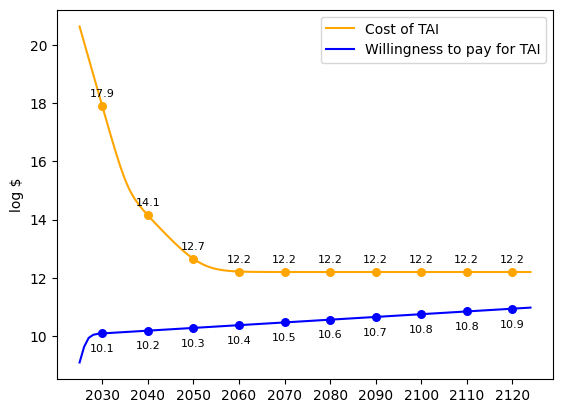

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 37.1 log FLOP (~12.6 thousand decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~573.5 quadrillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~648.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~259.3 million).
* This doubles every 0.9 year to a max of 0.002958% of GDP (initially ~743.3 million 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 37.1 logFLOP which costs 19.3 log 2025$USD to buy vs. WTP at 8.3 (buys 26.0 log FLOP or 26.0 2025-log-eFLOP)
2026 - TAI takes 36.9 logFLOP which costs 19.0 log 2025$USD to buy vs. WTP at 8.5 (buys 26.4 log FLOP or 26.6 2025-log-eFLOP)
2027 - TAI takes 36.6 logFLOP which costs 18.6 log 2025$USD to buy vs. WTP at 8.7 (buys 26.7 log FLOP or 27.2 2025-log-eFLOP)
2028 - TAI takes 36.4 logFL

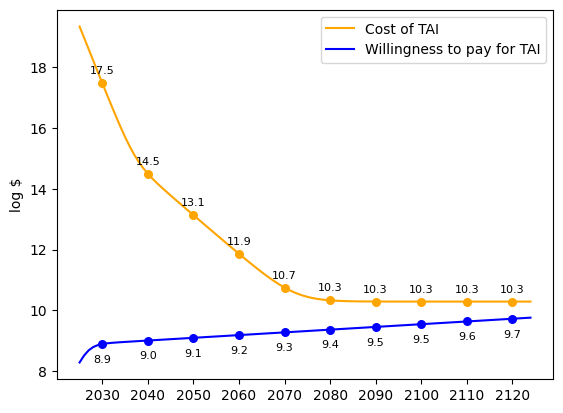

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 52.5 log FLOP (~31.6 quintillion decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 7 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 20.8 log FLOP (~673.7 quintillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~743.7 million).
* This doubles every 1.4 year to a max of 0.046135% of GDP (initially ~11.7 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 52.5 logFLOP which costs 34.4 log 2025$USD to buy vs. WTP at 8.8 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 52.2 logFLOP which costs 33.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 51.9 logFLOP which costs 33.5 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 51.5 logF

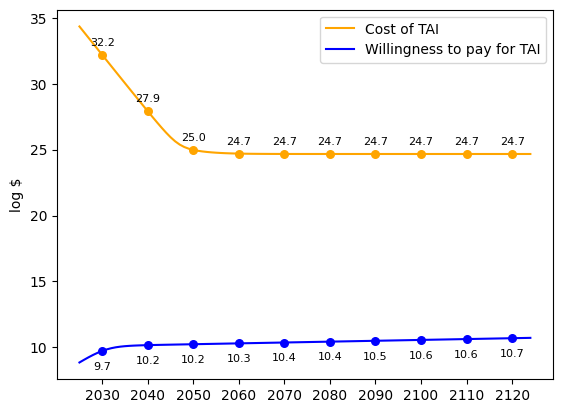

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.9 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~18.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~678.4 million).
* This doubles every 1.4 year to a max of 0.008408% of GDP (initially ~2.1 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 26.4 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.1 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 5 yea

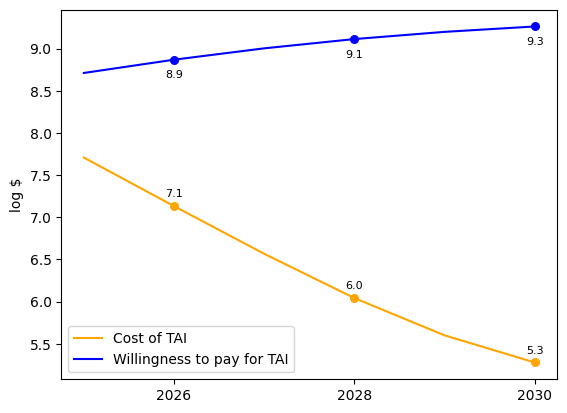

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 33.4 log FLOP (~2.5 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~41.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.6 billion).
* This doubles every 0.5 year to a max of 0.294329% of GDP (initially ~74.1 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 33.4 logFLOP which costs 15.4 log 2025$USD to buy vs. WTP at 9.2 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 33.0 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 9.8 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 32.6 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 10.4 (buys 28.6 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 32.2 logFLOP which costs 

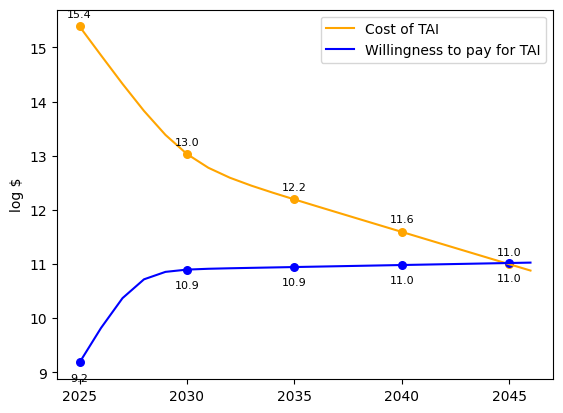

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 29.8 log FLOP (~631.0 octillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.8 quintillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~127.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.4 billion).
* This doubles every 1.1 year to a max of 0.098177% of GDP (initially ~24.5 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 29.8 logFLOP which costs 11.1 log 2025$USD to buy vs. WTP at 9.5 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 29.4 logFLOP which costs 10.5 log 2025$USD to buy vs. WTP at 9.7 (buys 28.5 log FLOP or 29.0 2025-log-eFLOP)
2027 - TAI takes 28.9 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 9.9 (buys 28.9 log FLOP or 29.8 2025-log-eFLOP)
2028 - TAI takes 28.5 logFLOP which costs

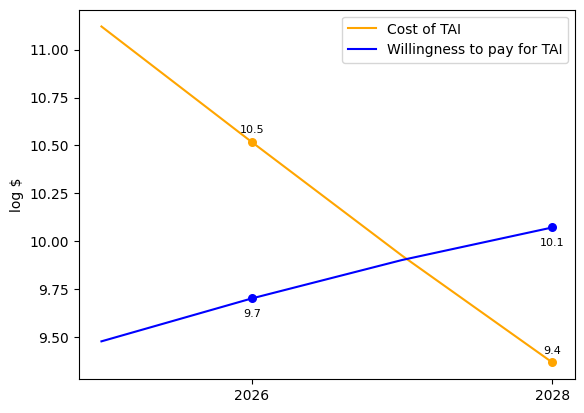

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 30.4 log FLOP (~2.5 nonillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~968.4 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~79.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~434.3 million).
* This doubles every 0.9 year to a max of 0.003841% of GDP (initially ~958.4 million 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 30.4 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 8.5 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 30.2 logFLOP which costs 12.1 log 2025$USD to buy vs. WTP at 8.7 (buys 26.8 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 30.0 logFLOP which costs 11.8 log 2025$USD to buy vs. WTP at 8.8 (buys 27.1 log FLOP or 27.4 2025-log-eFLOP)
2028 - TAI takes 29.8 logFLOP which co

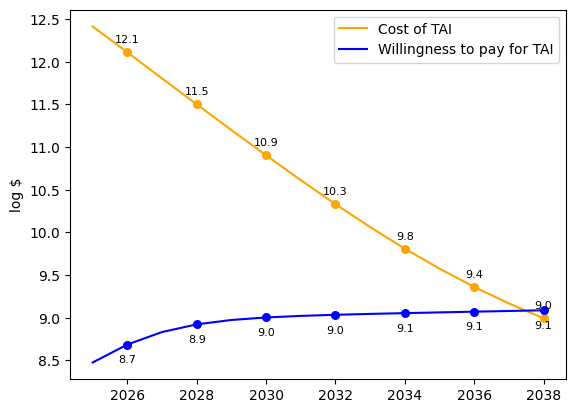

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 34.7 log FLOP (~50.1 decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.7 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~117.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.7 billion).
* This doubles every 1.3 year to a max of 0.032429% of GDP (initially ~8.1 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 34.7 logFLOP which costs 16.1 log 2025$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 34.4 logFLOP which costs 15.7 log 2025$USD to buy vs. WTP at 9.5 (buys 28.2 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 34.1 logFLOP which costs 15.3 log 2025$USD to buy vs. WTP at 9.6 (buys 28.4 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 33.7 logFLOP which costs 

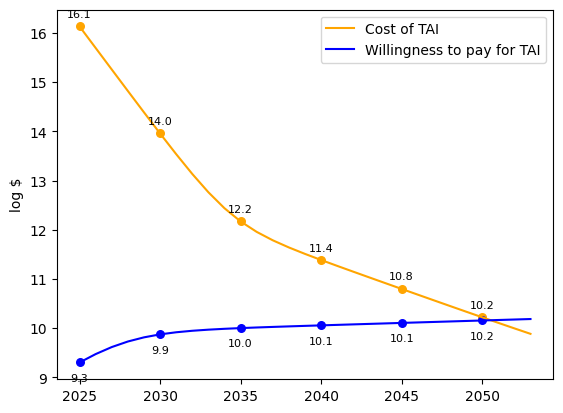

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 28.3 log FLOP (~20.0 octillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.2 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~596.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.1 billion).
* This doubles every 0.8 year to a max of 0.014457% of GDP (initially ~3.6 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 28.3 logFLOP which costs 9.8 log 2025$USD to buy vs. WTP at 8.9 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 28.1 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 28.0 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 9.4 (buys 28.1 log FLOP or 28.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.15 -> No

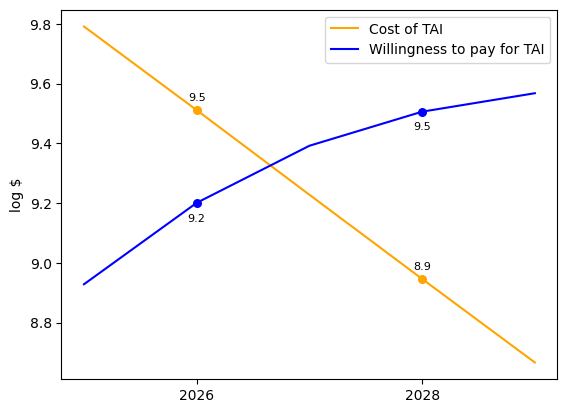

In [16]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [17]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2025-01-08 14:40:20.676440
